# Implement an encoder-decoder architecture for Image Captioning.

## Getting Dataset Ready!

### Downloading the data

In [1]:
# dowunload the dataset if it is not already downloaded
from pathlib import Path
dataset_path = Path("data")
dataset_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"

if not (dataset_path/"Flicker8k_Dataset").exists():
    print("Downloading dataset...")
    dataset_path.mkdir(parents=True,exist_ok=True)
    !wget -O {dataset_path/"Flicker8k_Dataset.zip"} {dataset_url}
    print("Unzipping dataset...")
    !unzip -q {dataset_path/"Flicker8k_Dataset.zip"} -d {dataset_path}
    print("Done!")
else:
    print("Dataset already downloaded!")

Dataset already downloaded!


In [2]:
# dowunload the dataset if it is not already downloaded
from pathlib import Path
dataset_path = Path("data")
dataset_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

if not (dataset_path/"Flickr8k_text").exists():
    print("Downloading dataset...")
    dataset_path.mkdir(parents=True,exist_ok=True)
    !wget -O {dataset_path/"Flickr8k_text.zip"} {dataset_url}
    print("Unzipping dataset...")
    !unzip -q {dataset_path/"Flickr8k_text.zip"} -d {dataset_path/"Flickr8k_text"}
    print("Done!")
else:
    print("Dataset already downloaded!")

Dataset already downloaded!


### Creating CSV file

In [3]:
# creating csv file
import pandas as pd
from pathlib import Path
from PIL import Image
img_path = Path("data/Flicker8k_Dataset")
train_path = Path("data/Flickr8k_text/Flickr_8k.trainImages.txt")
captions_path = Path("data/Flickr8k_text/Flickr8k.token.txt")

train_data_dict = {"image_path":[],"image_name":[],"caption":[]}

if not Path("data/Flickr8k_text/train_data.csv").exists():
    with open(captions_path) as f:
        captions = f.readlines()
        for line in captions:
            line = line.removesuffix("\n")
            img_name = line.split("\t")[0].split(".")[0]
            caption = line.split("\t")[1]
            try:
                Image.open(img_path/f"{img_name}.jpg")
            except:
                continue
            train_data_dict["image_path"].append(img_path/f"{img_name}.jpg")
            train_data_dict["caption"].append(caption)
            train_data_dict["image_name"].append(img_name)
    train_data = pd.DataFrame(train_data_dict)
    train_data.to_csv(f"data/Flickr8k_text/train_data.csv",index=False)
    print("CSV file created!")
else:
    print("CSV file already created!")

CSV file already created!


In [4]:
train_data = pd.read_csv("data/Flickr8k_text/train_data.csv")
train_data.head()

,image_path,image_name,caption
0,data/Flicker8k_Dataset/1000268201_693b08cb0e.jpg,1000268201_693b08cb0e,A child in a pink dress is climbing up a set o...
1,data/Flicker8k_Dataset/1000268201_693b08cb0e.jpg,1000268201_693b08cb0e,A girl going into a wooden building .
2,data/Flicker8k_Dataset/1000268201_693b08cb0e.jpg,1000268201_693b08cb0e,A little girl climbing into a wooden playhouse .
3,data/Flicker8k_Dataset/1000268201_693b08cb0e.jpg,1000268201_693b08cb0e,A little girl climbing the stairs to her playh...
4,data/Flicker8k_Dataset/1000268201_693b08cb0e.jpg,1000268201_693b08cb0e,A little girl in a pink dress going into a woo...


### Creating Dataset class

In [5]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms

# We want to convert text -> numerical values
# 1. We need a Vocabulary mapping each word to a index
# 2. We need to setup a Pytorch dataset to load the data
# 3. Setup padding of every batch (all examples should be
#    of same seq_len and setup dataloader)
# Note that loading the image is very easy compared to the text!

# Download with: python -m spacy download en
try:
    spacy_eng = spacy.blank("en")
except:
    os.system("python -m -q spacy download en")
finally:
    spacy_eng = spacy.blank("en")


class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image_name"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index] + ".jpg"
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset


# if __name__ == "__main__":
#     transform = transforms.Compose(
#         [transforms.Resize((224, 224)), transforms.ToTensor(),]
#     )

#     loader, dataset = get_loader(
#         "data/Flicker8k_Dataset/", "data/Flickr8k_text/train_data.csv", transform=transform
#     )

#     for idx, (imgs, captions) in enumerate(loader):
#         print(imgs.shape)
#         print(captions.shape)

In [14]:
from torchvision import transforms
image_transforms = transforms.Compose([
    transforms.Resize((224,244)),
    transforms.ToTensor(),
])

import torch
SPLIT_SIZE = 0.8
BATCH_SIZE = 32

loader, dataset = get_loader("data/Flicker8k_Dataset/", "data/Flickr8k_text/train_data.csv", transform=image_transforms)

train_data, test_data = torch.utils.data.random_split(loader.dataset, [int(len(dataset)*SPLIT_SIZE), len(dataset) - int(len(dataset)*SPLIT_SIZE)], generator=torch.Generator().manual_seed(42))

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Train data size: {len(train_data)}")
print(f"test data size: {len(test_data)}")
print(f"train dataloader size: {len(train_dataloader)}")
print(f"test dataloader size: {len(test_dataloader)}")

Train data size: 32364
test data size: 8091
train dataloader size: 1012
test dataloader size: 253


In [7]:
# print(f"firt batch size: {len(next(iter(train_dataloader)))}")
print("first batch:")
# next(iter(train_dataloader))

first batch:


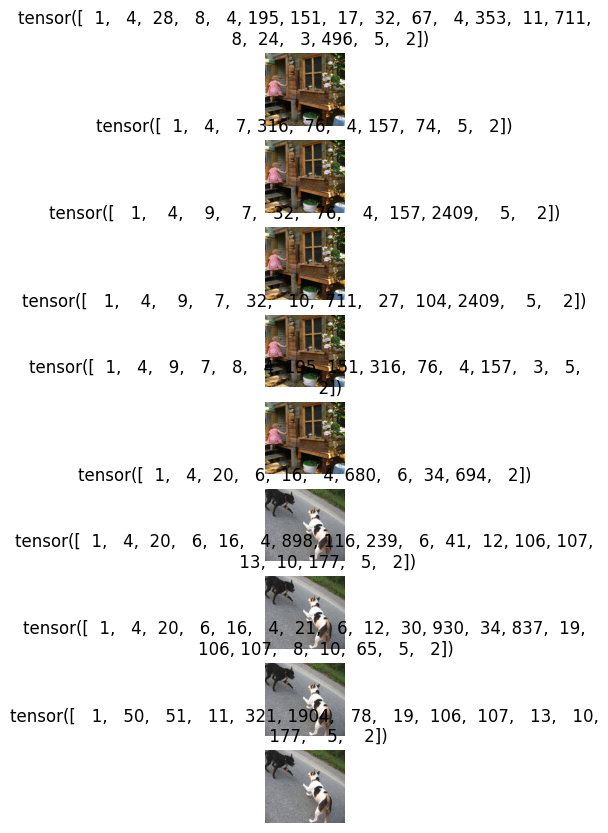

In [8]:
# visualizing the data
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3*3,1,i+1)
    plt.imshow(dataset[i][0].permute(1,2,0))
    plt.axis("off")
    plt.title(dataset[i][1])
plt.show()

## Defining the models

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models


class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.resnet = models.resnet18(weights="DEFAULT", progress=True)
        
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.resnet(images)
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.inference_mode():
            x = self.encoderCNN(image.unsqueeze(0))
            # print(f"x shape: {x.shape}")
            states = None

            for _ in range(max_length):
                
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(-1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [11]:
# Training the models
# num of epochs
EPOCHS = 100

# model initialization
model = CNNtoRNN(embed_size=512, hidden_size=512, vocab_size=len(dataset.vocab), num_layers=1).to(device)

# loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)


In [12]:
from tqdm.auto import tqdm
# loop over the dataset multiple times
loss_list = []
for epoch in tqdm(range(EPOCHS)):
    loss_ = 0.0
    for idx, (imgs, captions) in tqdm(
        enumerate(loader), total=len(loader), leave=True
    ):
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions[:-1])
        loss = loss_fn(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )
        loss_ += loss.item()
        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()
    print(f"Epoch: {epoch}, Loss: {loss_/len(loader)}")
    loss_list.append(loss_/len(loader))
# save the model
torch.save(model.state_dict(), "image_captioning_model.pth")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 0, Loss: 1.9007006916604023


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 1, Loss: 1.5677726191494306


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 2, Loss: 1.455915383058103


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 3, Loss: 1.3878132536006067


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 4, Loss: 1.3384710098443766


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 5, Loss: 1.2989802183369874


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 6, Loss: 1.2717213764963413


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 7, Loss: 1.2438420370633423


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 8, Loss: 1.222792835810439


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 9, Loss: 1.1953538992188193


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 10, Loss: 1.180117584641272


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 11, Loss: 1.1655158281797477


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 12, Loss: 1.1472289254071684


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 13, Loss: 1.1371016512746397


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 14, Loss: 1.1230017276620676


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 15, Loss: 1.1113724363180018


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 16, Loss: 1.1031981822530272


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 17, Loss: 1.0917020912698134


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 18, Loss: 1.0796643764133982


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 19, Loss: 1.0743841062421384


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 20, Loss: 1.0633496802786122


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 21, Loss: 1.0606625259629352


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 22, Loss: 1.0521565268162212


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 23, Loss: 1.0463324190599645


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 24, Loss: 1.0370292821891693


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 25, Loss: 1.0337789587352586


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 26, Loss: 1.0267261139960158


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 27, Loss: 1.0213435573540186


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 28, Loss: 1.0229502042291665


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 29, Loss: 1.0150718492010364


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 30, Loss: 1.008954273617786


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 31, Loss: 1.0041825537153855


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 32, Loss: 1.0030675147361907


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 33, Loss: 0.9969916095846727


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 34, Loss: 0.993267046462877


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 35, Loss: 0.9909407417293594


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 36, Loss: 0.9869783856652


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 37, Loss: 0.98473588911441


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 38, Loss: 0.9818685034989368


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 39, Loss: 0.9778920684407351


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 40, Loss: 0.9765701203949366


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 41, Loss: 0.9688639766142774


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 42, Loss: 0.9702880338246643


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 43, Loss: 0.9632469117405857


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 44, Loss: 0.968501420218954


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 45, Loss: 0.9634062936183492


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 46, Loss: 0.9607952213570063


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 47, Loss: 0.9562251537213684


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 48, Loss: 0.9546274428311072


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 49, Loss: 0.9549505675263085


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 50, Loss: 0.9543416059535482


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 51, Loss: 0.9528579695422659


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 52, Loss: 0.9454257631961536


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 53, Loss: 0.9478358078851059


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 54, Loss: 0.9456439890880358


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 55, Loss: 0.9418709173975255


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 56, Loss: 0.9425607933828481


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 57, Loss: 0.9407667674094792


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 58, Loss: 0.935864056947203


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 59, Loss: 0.9376662605364803


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 60, Loss: 0.9341788974675265


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 61, Loss: 0.935732948968533


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 62, Loss: 0.9338434215590888


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 63, Loss: 0.9341562245674284


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 64, Loss: 0.9307414029426726


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 65, Loss: 0.9286303756736484


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 66, Loss: 0.9293038643867131


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 67, Loss: 0.9286740908038474


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 68, Loss: 0.9248541973325104


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 69, Loss: 0.9240857325994921


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 70, Loss: 0.926358347683556


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 71, Loss: 0.9216753595431332


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 72, Loss: 0.9182620386361133


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 73, Loss: 0.9233748051017641


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 74, Loss: 0.9215162521294454


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 75, Loss: 0.9156978152014993


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 76, Loss: 0.9187678586824138


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 77, Loss: 0.9189472960860362


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 78, Loss: 0.914993492322477


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 79, Loss: 0.9142504061634833


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 80, Loss: 0.9157122137989451


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 81, Loss: 0.911435816410502


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 82, Loss: 0.9132724758193427


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 83, Loss: 0.9138937432304202


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 84, Loss: 0.9120524191573675


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 85, Loss: 0.9089495297005996


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 86, Loss: 0.9121633604581177


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 87, Loss: 0.9098409126398591


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 88, Loss: 0.9111054341783636


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 89, Loss: 0.909277634941071


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 90, Loss: 0.9096239735486479


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 91, Loss: 0.9046951055526733


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 92, Loss: 0.9067069137991652


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 93, Loss: 0.908321827626511


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 94, Loss: 0.9059589318135981


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 95, Loss: 0.9015148547327094


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 96, Loss: 0.9058137779650481


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 97, Loss: 0.903650178598321


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 98, Loss: 0.9070959908688964


  0%|          | 0/1265 [00:00<?, ?it/s]

Epoch: 99, Loss: 0.905024681025343


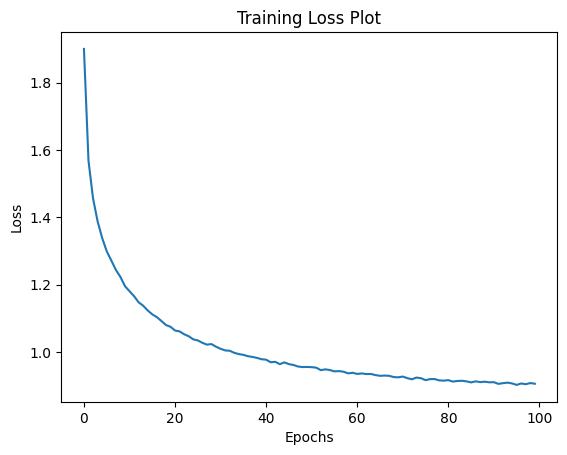

In [13]:
plt.plot(loss_list)
plt.title("Training Loss Plot")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [15]:
# loading the saved model
model = CNNtoRNN(embed_size=512, hidden_size=512, vocab_size=len(dataset.vocab), num_layers=1).to(device)
model.load_state_dict(torch.load("image_captioning_model.pth"))
model.eval()

CNNtoRNN(
  (encoderCNN): EncoderCNN(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Bat

In [17]:
# calculating the bleu score and proplexity
from tqdm.auto import tqdm
from nltk.translate.bleu_score import sentence_bleu

def evaluate(model, loader, vocabulary, device):
    loss_, ppl = 0.0, 0.0
    for idx, (imgs, captions) in tqdm(
        enumerate(loader), total=len(loader), leave=True
    ):
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions[:-1])
        loss = loss_fn(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )
        loss_ += loss.item()
        ppl += torch.exp(loss).item()
    return loss_/len(loader), ppl/len(loader)
        

loss, ppl = evaluate(model, loader, dataset.vocab, device)
print(f"Loss: {loss}, Perplexity: {ppl}")

  0%|          | 0/1265 [00:00<?, ?it/s]

Loss: 0.699483488506008, Perplexity: 2.0195523009469856


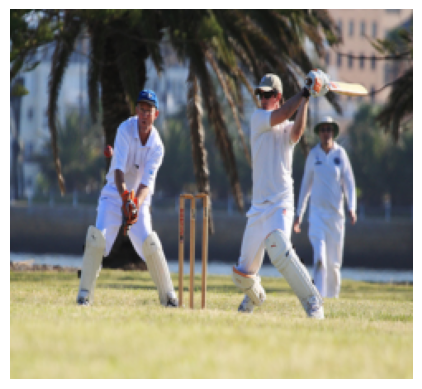

Actual: these people are in uniform at a lacrosse type game .
Prediction: <SOS> a man in a white shirt kicked a goal shot . <EOS>


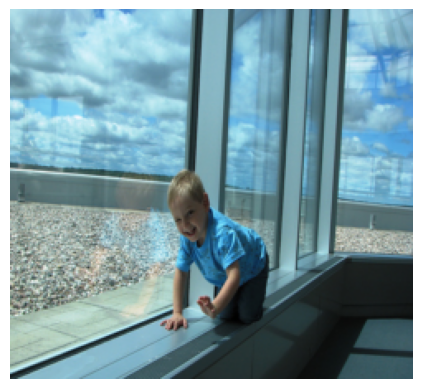

Actual: a small boy in blue crawls along a window <UNK> .
Prediction: <SOS> a little boy is jumping off a pier into a swimming pool . <EOS>


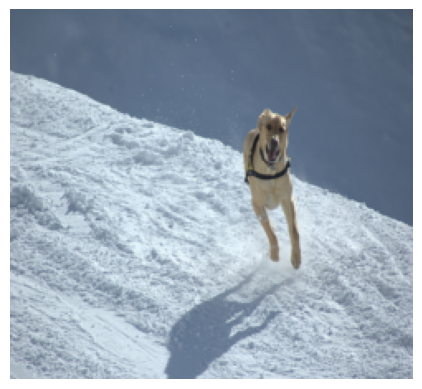

Actual: a dog running through snow .
Prediction: <SOS> a dog running through snow . <EOS>


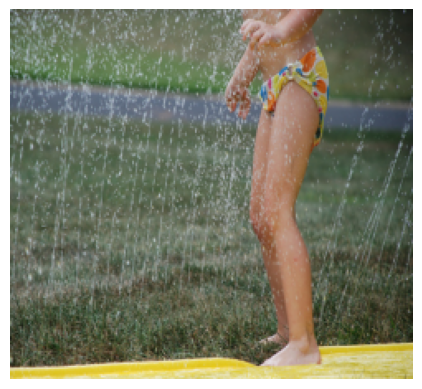

Actual: a child seen from the waist down in a bathing suit standing on a slip and slide with <UNK> of water shooting up
Prediction: <SOS> a little girl in a bathing suit is holding a paddle in her hands . <EOS>


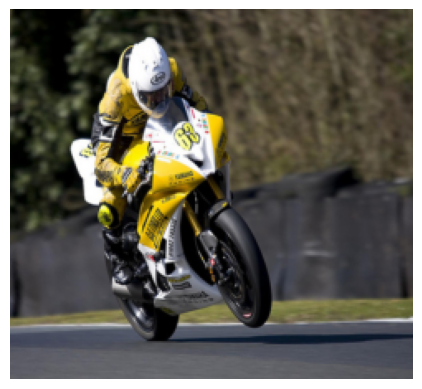

Actual: a yellow motorcycle drives down the road .
Prediction: <SOS> a man in a yellow helmet riding a motorcycle . <EOS>


In [18]:
# getting the predictions
import matplotlib.pyplot as plt

for _ in range(5):
    idx = torch.randint(0, len(test_data), ())
    img, caption = test_data[idx]
    img = img.to(device)
    plt.imshow(img.cpu().permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    print("Actual:", " ".join([dataset.vocab.itos[idx] for idx in caption.tolist()[1:-1]]))
    print("Prediction:", " ".join(model.caption_image(img, dataset.vocab)))